In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
import pandas as pd
import numpy as np
from datetime import datetime
import numpy as np
from collections import Counter

In [2]:

def find_satellite_position_and_neighbors(sat_num, time_str):
    # Convert input time string to datetime object (in HH_MM_SS format)
    input_time = datetime.strptime(time_str, '%H_%M_%S').time()
    
    # Set the correct folder path for satellite position files
    folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\pos"
    
    # Read the satellite's position file
    sat_file = os.path.join(folder_path, f"{sat_num}.csv")
    
    try:
        sat_data = pd.read_csv(sat_file)
    except FileNotFoundError:
        print(f"Error: The file {sat_file} does not exist.")
        return None
    
    # Clean column names by stripping leading/trailing spaces
    sat_data.columns = sat_data.columns.str.strip()
    
    # Ensure the 'Time' column is in datetime format, accounting for timezone
    sat_data['Time'] = pd.to_datetime(sat_data['Time'], errors='coerce')  # Handle invalid parsing
    
    # Adjust the 'Time' column to match HH_MM_SS format (start from 16:00:00 and increment 20s)
    start_time = datetime.strptime("16:00:00", "%H:%M:%S")  # Start at 16:00:00
    sat_data['Time_Formatted'] = pd.date_range(start=start_time, periods=len(sat_data), freq='20s').strftime('%H_%M_%S')
    
    # Function to convert time to seconds since midnight
    def time_to_seconds(t):
        return t.hour * 3600 + t.minute * 60 + t.second

    # Find the closest time in the satellite's data by calculating the absolute time difference in seconds
    sat_data['time_diff'] = sat_data['Time_Formatted'].apply(
        lambda x: abs(time_to_seconds(datetime.strptime(x, '%H_%M_%S').time()) - time_to_seconds(input_time))
    )
    
    closest_row = sat_data.loc[sat_data['time_diff'].idxmin()]

    # Ensure columns are present before accessing
    required_columns = ['Latitude', 'Longitude', 'Altitude']
    if all(col in closest_row for col in required_columns):
        sat_position = closest_row[required_columns]
    else:
        print(f"Error: Missing one or more required columns {required_columns} in the closest row")
        return None

    # Read the optimal data file for the given time
    optimal_folder = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Optimal with position"
    optimal_file = os.path.join(optimal_folder, f"optimal_file_data_{time_str}.csv")
    
    if not os.path.exists(optimal_file):
        print(f"Error: The optimal file {optimal_file} does not exist.")
        return None
    
    try:
        optimal_data = pd.read_csv(optimal_file)
    except Exception as e:
        print(f"Error reading the optimal file: {e}")
        return None
    
    # Extract relevant columns (feed_sat, Latitude, Longitude, Altitude) from optimal data
    relevant_data = optimal_data[['feed_sat', 'Latitude', 'Longitude', 'Altitude']]
    
    # Remove duplicate satellites based on 'feed_sat' column
    unique_satellite_positions = relevant_data.drop_duplicates(subset=['feed_sat'])

    # Calculate distances to all other satellites
    distances = []
    for _, row in unique_satellite_positions.iterrows():
        if row['feed_sat'] != sat_num:
            dist = np.sqrt((row['Latitude'] - sat_position['Latitude'])**2 +
                           (row['Longitude'] - sat_position['Longitude'])**2 +
                           (row['Altitude'] - sat_position['Altitude'])**2)
            distances.append((row['feed_sat'], dist, row['Latitude'], row['Longitude'], row['Altitude']))
    
    # Sort distances and get the 4 nearest neighbors
    nearest_neighbors = sorted(distances, key=lambda x: x[1])[:4]

    # Construct the output dictionary
    output = {
        'satellite': sat_num,
        'time': time_str,
        'position': sat_position.to_dict()
    }

    # Add nearest neighbors and their positions
    for i, (neighbor, _, lat, lon, alt) in enumerate(nearest_neighbors, start=1):
        output[f'nearest neighbor {i}'] = neighbor
        output[f'neighbor {i} position'] = {'Latitude': lat, 'Longitude': lon, 'Altitude': alt}

    return output

In [3]:
# Function to generate filenames based on time intervals
def generate_time_file_names(start_time_str, end_time_str, folder_path, prefix='optimal_file_data_'):
    start_time = datetime.strptime(start_time_str, '%H_%M_%S')
    end_time = datetime.strptime(end_time_str, '%H_%M_%S')
    current_time = start_time
    while current_time <= end_time:
        time_str = current_time.strftime('%H_%M_%S')
        file_name = f"{prefix}{time_str}.csv"
        yield os.path.join(folder_path, file_name)
        current_time += timedelta(seconds=20)

# Function to load data from multiple files
def load_data(file_names):
    data_list = []
    for file_name in file_names:
        if os.path.exists(file_name):
            df = pd.read_csv(file_name)
            data_list.append(df)
        else:
            print(f"File not found: {file_name}")
    return pd.concat(data_list, ignore_index=True)

# Set Training and Testing Time Ranges
start_time = datetime.strptime('16_00_00', '%H_%M_%S')
train_end_time = (start_time + timedelta(hours=3)).strftime('%H_%M_%S')  # First 4.5 hours for training
test_start_time = train_end_time
test_end_time = (start_time + timedelta(hours=4, minutes=30)).strftime('%H_%M_%S')  # Next 1.5 hours for testing

# Convert times to strings
start_time_train = start_time.strftime('%H_%M_%S')
end_time_train = train_end_time
start_time_test = test_start_time
end_time_test = test_end_time

# Set folder path
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position"

# Generate file names for training and testing
generate_train_files = generate_time_file_names(start_time_train, end_time_train, folder_path)
generate_test_files = generate_time_file_names(start_time_test, end_time_test, folder_path)

# Load training and testing data
train_data = load_data(list(generate_train_files))
test_data = load_data(list(generate_test_files))

In [4]:
# Verify generated file paths
train_files = list(generate_time_file_names(start_time_train, end_time_train, folder_path))
test_files = list(generate_time_file_names(start_time_test, end_time_test, folder_path))

print(f"Training Files: {len(train_files)}")
print(train_files[:5])  # Show first 5 training files
print(f"Testing Files: {len(test_files)}")
print(test_files[:5])  # Show first 5 testing files


Training Files: 541
['C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_16_00_00.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_16_00_20.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_16_00_40.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_16_01_00.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_16_01_20.csv']
Testing Files: 271
['C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_19_00_00.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_19_00_20.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_19_00_40.csv', 'C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position\\optimal_file_data_19_01_00.csv', 'C:\\Users\\aruna\\Desk

In [5]:
def get_unique_feed_sats(file_name):
    if not os.path.exists(file_name):
        print(f"File not found: {file_name}")
        return set()
    
    df = pd.read_csv(file_name)
    return set(df['feed_sat'].unique())

# Verify with one file
sample_file = train_files[0]
unique_sats = get_unique_feed_sats(sample_file)
print(f"Unique feed_sats in {sample_file}: {len(unique_sats)}")


Unique feed_sats in C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_00_00.csv: 108


GNN model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import joblib
from datetime import datetime, timedelta
from collections import Counter

# Load trained NN model
model = tf.keras.models.load_model('gateway_model.h5')
scaler = joblib.load('scaler.save')

# Latitude and Longitude Bounds
LAT_MIN, LAT_MAX = 20.47793336675211, 53.14935832691079
LON_MIN, LON_MAX = -137.2887982915139, -55.267811105233406

# Generate file names
def generate_time_file_names(start_time_str, num_files=10, folder_path="C:\\Users\\aruna\\Desktop\\MS Thesis\\Real Data\\Files with position", prefix='optimal_file_data_'):
    start_time = datetime.strptime(start_time_str, '%H_%M_%S')
    current_time = start_time
    time_files = []
    
    for _ in range(num_files):
        time_str = current_time.strftime('%H_%M_%S')
        file_name = f"{prefix}{time_str}.csv"
        time_files.append(os.path.join(folder_path, file_name))
        current_time += timedelta(seconds=20)
    
    return time_files

start_time_str = '16_00_00'
training_files = generate_time_file_names(start_time_str, num_files=10)

### 1️⃣ Load Satellite Data ###
def load_satellite_data(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return []

    df = pd.read_csv(file_path)
    
    # Apply bounds and filter unique satellites
    df = df[(df['Latitude'] >= LAT_MIN) & (df['Latitude'] <= LAT_MAX) & (df['Longitude'] >= LON_MIN) & (df['Longitude'] <= LON_MAX)]
    df = df.drop_duplicates(subset=['feed_sat'])
    
    # Create satellite objects
    satellites = [{'id': int(row['feed_sat']), 
                   'position': {'Latitude': row['Latitude'], 'Longitude': row['Longitude'], 'Altitude': row['Altitude']},
                   'actual_gateway': int(row['gw'])} for _, row in df.iterrows()]
    
    return satellites

### 2️⃣ Predict Top-3 Gateways ###
def predict_gateways_for_satellites(satellites):
    if not satellites:
        return []

    positions = np.array([[sat['position']['Latitude'], sat['position']['Longitude'], sat['position']['Altitude']] for sat in satellites])
    positions_scaled = scaler.transform(positions)
    predictions = model.predict(positions_scaled)
    top_3_gateways = np.argsort(predictions, axis=1)[:, -3:]

    for i, sat in enumerate(satellites):
        sat['predicted_gateways'] = top_3_gateways[i].tolist()

    return satellites

### 3️⃣ Find Nearest Neighbors ###
def find_nearest_neighbors(satellites, k=6):
    positions = np.array([[sat['position']['Latitude'], sat['position']['Longitude']] for sat in satellites])
    edges = []
    
    for i in range(len(satellites)):
        dists = np.linalg.norm(positions - positions[i], axis=1)
        nearest_indices = np.argsort(dists)[1:k+1]  # Find nearest neighbors
        edges.extend([(i, j) for j in nearest_indices])
    
    return edges


### 4️⃣ Assign Gateways Based on Neighborhood ###
def assign_gateways_consistently(satellites, edges):
    """
    Assigns a final gateway for each satellite, ensuring the gateway is **strictly within** the predicted set.
    Uses neighborhood consistency to prioritize frequently occurring gateways.
    """
    # Convert edge list to adjacency dictionary
    adjacency_dict = {i: [] for i in range(len(satellites))}
    for i, j in edges:
        adjacency_dict[i].append(j)
        adjacency_dict[j].append(i)

    # Assign final gateways based on neighbors
    for i, sat in enumerate(satellites):
        possible_gateways = set(sat['predicted_gateways'])  # Only consider predicted gateways

        # Get neighboring satellites' predicted gateways
        neighbor_gateways = []
        for neighbor in adjacency_dict[i]:
            neighbor_gateways.extend(satellites[neighbor]['predicted_gateways'])

        # Find the most common gateway in the intersection
        common_gateways = [g for g in neighbor_gateways if g in possible_gateways]

        if common_gateways:
            # Choose the most frequently occurring gateway in common_gateways
            assigned_gateway = Counter(common_gateways).most_common(1)[0][0]
        else:
            # If no agreement, fall back to the first predicted gateway
            assigned_gateway = sat['predicted_gateways'][0]

        sat['final_gateway_assigned'] = assigned_gateway  # **Always in the predicted set**

    return satellites


### 5️ Construct Graph ###
def construct_graph(satellites, edges):
    num_gateways = 54  # Total number of possible gateways
    node_features = []

    for sat in satellites:
        lat, lon, alt = sat['position']['Latitude'], sat['position']['Longitude'], sat['position']['Altitude']
        predicted_gateways = sat.get('predicted_gateways', [])

        # Ensure exactly 3 predicted gateways (pad if needed)
        while len(predicted_gateways) < 3:
            predicted_gateways.append(0)  # Use 0 as a placeholder for missing values

        # One-hot encode the predicted gateways
        one_hot_gateways = np.zeros(num_gateways, dtype=np.float32)
        for gw in predicted_gateways:
            if 0 <= gw < num_gateways:  # Ensure it's within bounds
                one_hot_gateways[gw] = 1  

        # Feature vector should have exactly 57 features
        feature_vector = [lat, lon, alt] + list(one_hot_gateways)
        
        if len(feature_vector) != 57:
            print(f"⚠ Feature vector length mismatch: {len(feature_vector)} for satellite {sat['id']}")
            print(f"Predicted gateways: {predicted_gateways}")
            print(f"One-hot encoding: {one_hot_gateways}")
            print(f"Lat: {lat}, Lon: {lon}, Alt: {alt}")
        
        assert len(feature_vector) == 57, f"Feature vector length mismatch: {len(feature_vector)}"

        node_features.append(feature_vector) ###

    # Convert to PyTorch tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print(f"✅ Final Feature Vector Shape: {node_features.shape}")  # Debugging
    return Data(x=node_features, edge_index=edge_index)



### 6️⃣ Define GNN Model ###
class GNNModel(nn.Module):
    def __init__(self, input_dim=57, hidden_dim=128, output_dim=54):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_dim * 4)
        self.conv2 = GATConv(hidden_dim * 4, hidden_dim, heads=4, concat=True)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 4)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)  # Output = 54 (gateways)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.bn1(self.conv1(x, edge_index)))
        x = torch.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.fc(x)  # Output raw logits
        return x  # No softmax here




### 7 Custom Loss ###
def custom_loss(output, satellites):
    """
    Improved loss function: Uses CrossEntropyLoss correctly.
    """
    target_gateways = torch.tensor([sat['final_gateway_assigned'] for sat in satellites], dtype=torch.long)

    # CrossEntropyLoss expects raw logits, not softmax probabilities
    return nn.CrossEntropyLoss()(output, target_gateways)

    return nn.CrossEntropyLoss()(masked_output, target_gateways)

### 8 Train GNN Model ###
def train_gnn_model(satellites):
    edges = find_nearest_neighbors(satellites, k=4)
    satellites = assign_gateways_consistently(satellites, edges)
    graph_data = construct_graph(satellites, edges)

    print(f"Feature vector shape: {graph_data.x.shape}")  # Debugging step
    print(f"Edge index shape: {graph_data.edge_index.shape}")

    gnn_model = GNNModel(input_dim=57, hidden_dim=128, output_dim=54)  # Fix input dim
    optimizer = optim.Adam(gnn_model.parameters(), lr=0.005)
    
    epochs = 50
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = gnn_model(graph_data)
        loss = custom_loss(output, satellites)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    torch.save(gnn_model.state_dict(), 'gnn_model.pth')
    print("✅ GNN Model trained and saved.")




### 9 Process Data and Train ###
for file_path in training_files:
    satellites = load_satellite_data(file_path)
    if not satellites:
        continue
    satellites = predict_gateways_for_satellites(satellites)
    train_gnn_model(satellites)
    print(f"GNN Model trained for {file_path}.")


c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\aruna\AppData\Local\Programs\Python\Python39\lib\site-pa

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
✅ Final Feature Vector Shape: torch.Size([106, 57])
Feature vector shape: torch.Size([106, 57])
Edge index shape: torch.Size([2, 424])
Epoch 1/50, Loss: 4.1019
Epoch 2/50, Loss: 2.4994
Epoch 3/50, Loss: 1.9990
Epoch 4/50, Loss: 1.7062
Epoch 5/50, Loss: 1.5180
Epoch 6/50, Loss: 1.3706
Epoch 7/50, Loss: 1.2458
Epoch 8/50, Loss: 1.1476
Epoch 9/50, Loss: 1.0646
Epoch 10/50, Loss: 0.9969
Epoch 11/50, Loss: 0.9352
Epoch 12/50, Loss: 0.8768
Epoch 13/50, Loss: 0.8227
Epoch 14/50, Loss: 0.7715
Epoch 15/50, Loss: 0.7262
Epoch 16/50, Loss: 0.6820
Epoch 17/50, Loss: 0.6414
Epoch 18/50, Loss: 0.6003
Epoch 19/50, Loss: 0.5642
Epoch 20/50, Loss: 0.5298
Epoch 21/50, Loss: 0.4952
Epoch 22/50, Loss: 0.4613
Epoch 23/50, Loss: 0.4310
Epoch 24/50, Loss: 0.4022
Epoch 25/50, Loss: 0.3751
Epoch 26/50, Loss: 0.3492
Epoch 27/50, Loss: 0.3243
Epoch 28/50, Loss: 0.3022
Epoch 29/50, Loss: 0.2842
Epoch 30/50, Loss: 0.2639
Epoch 31/50, Loss: 0.2459
Epoch 32/50, Loss: 0.2290
Epoc

Testing code


Processing test file: C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_03_20.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Gateways without satellites: []


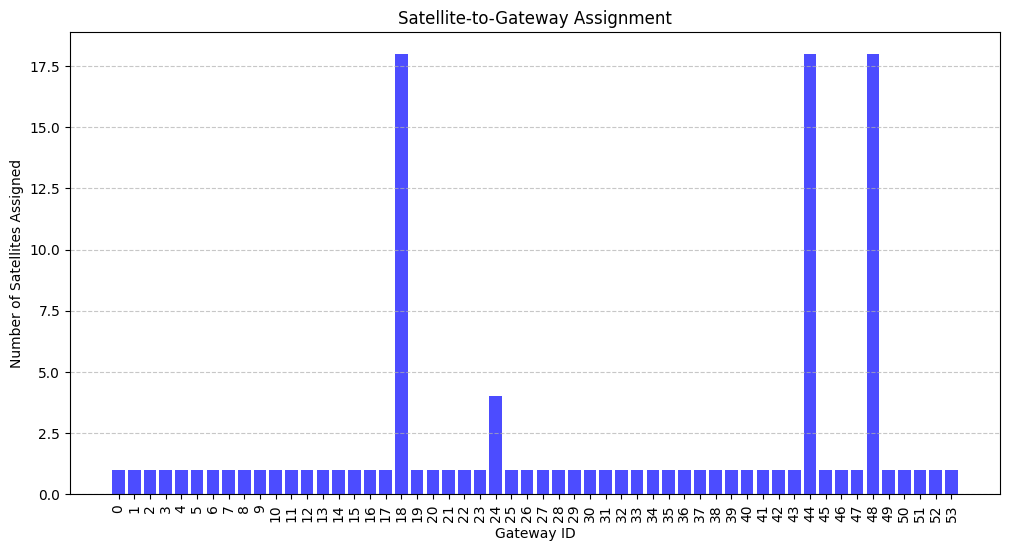


Sample Predictions:
Satellite 950 → Final Gateway: 45, Actual: 20
Satellite 1064 → Final Gateway: 8, Actual: 34
Satellite 1040 → Final Gateway: 0, Actual: 5
Satellite 1269 → Final Gateway: 10, Actual: 30
Satellite 1518 → Final Gateway: 49, Actual: 36
Satellite 905 → Final Gateway: 52, Actual: 42
Satellite 835 → Final Gateway: 1, Actual: 7
Satellite 1451 → Final Gateway: 2, Actual: 52
Satellite 1358 → Final Gateway: 3, Actual: 41
Satellite 1246 → Final Gateway: 12, Actual: 31

Processing test file: C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_03_40.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Gateways without satellites: []


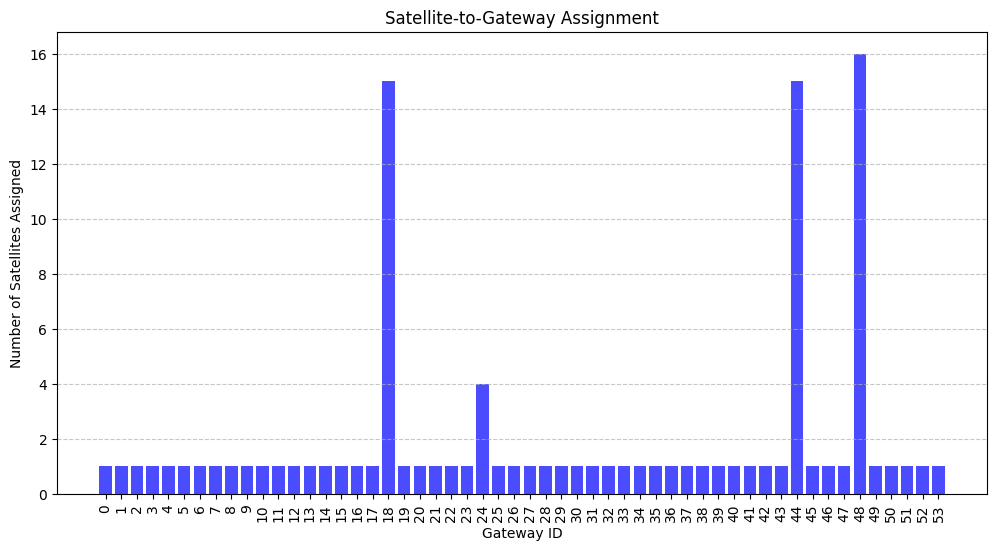


Sample Predictions:
Satellite 904 → Final Gateway: 50, Actual: 20
Satellite 1451 → Final Gateway: 0, Actual: 34
Satellite 926 → Final Gateway: 1, Actual: 5
Satellite 1269 → Final Gateway: 6, Actual: 30
Satellite 882 → Final Gateway: 53, Actual: 36
Satellite 905 → Final Gateway: 44, Actual: 42
Satellite 1267 → Final Gateway: 2, Actual: 7
Satellite 996 → Final Gateway: 44, Actual: 52
Satellite 1358 → Final Gateway: 3, Actual: 41
Satellite 1155 → Final Gateway: 8, Actual: 31

Processing test file: C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_04_00.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Gateways without satellites: []


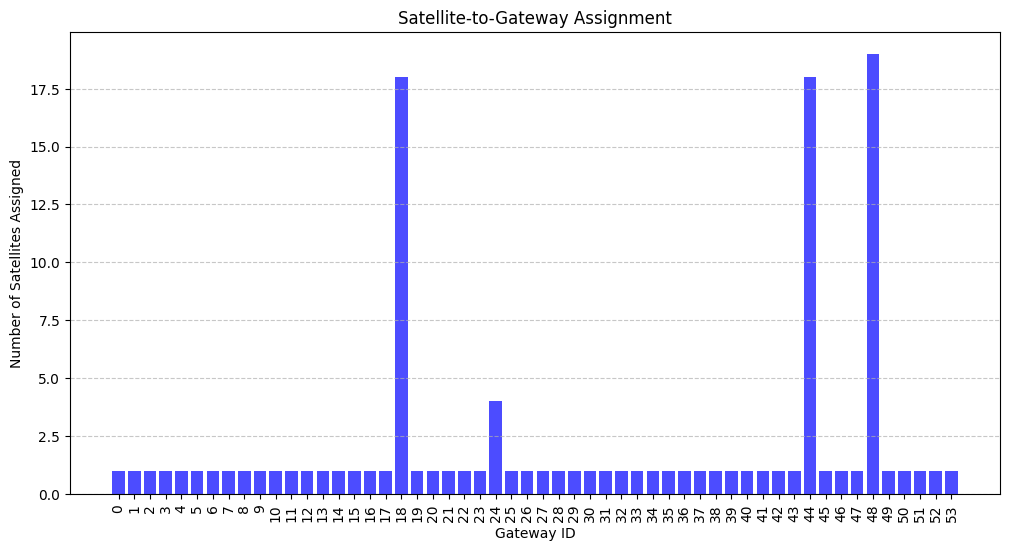


Sample Predictions:
Satellite 904 → Final Gateway: 42, Actual: 20
Satellite 1064 → Final Gateway: 4, Actual: 34
Satellite 995 → Final Gateway: 0, Actual: 5
Satellite 1269 → Final Gateway: 6, Actual: 30
Satellite 882 → Final Gateway: 46, Actual: 36
Satellite 1541 → Final Gateway: 50, Actual: 42
Satellite 1313 → Final Gateway: 1, Actual: 7
Satellite 996 → Final Gateway: 53, Actual: 52
Satellite 835 → Final Gateway: 2, Actual: 41
Satellite 1063 → Final Gateway: 3, Actual: 31

Processing test file: C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_04_20.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Gateways without satellites: []


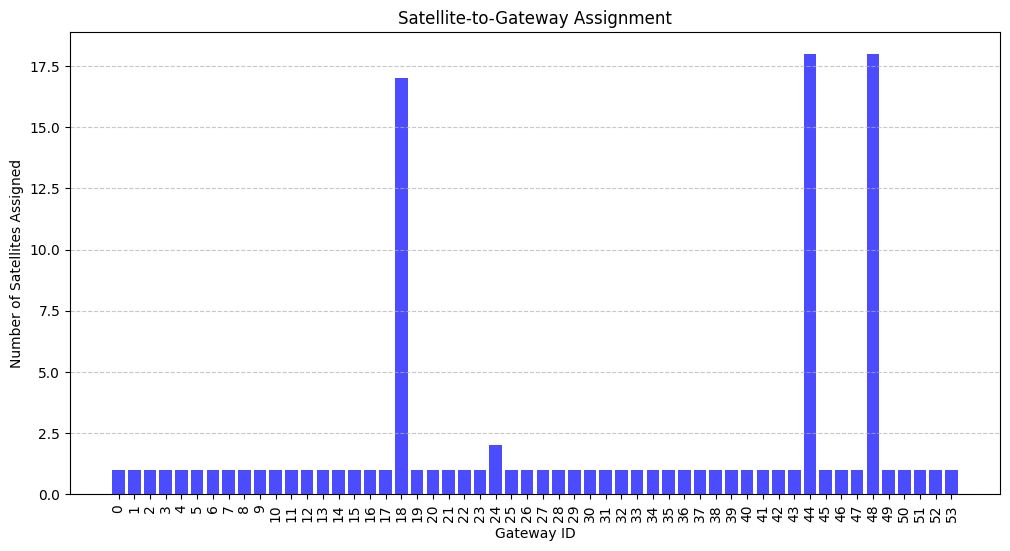


Sample Predictions:
Satellite 904 → Final Gateway: 43, Actual: 20
Satellite 995 → Final Gateway: 0, Actual: 34
Satellite 1222 → Final Gateway: 1, Actual: 5
Satellite 1109 → Final Gateway: 9, Actual: 30
Satellite 859 → Final Gateway: 47, Actual: 36
Satellite 1564 → Final Gateway: 51, Actual: 42
Satellite 1267 → Final Gateway: 2, Actual: 7
Satellite 1473 → Final Gateway: 44, Actual: 52
Satellite 880 → Final Gateway: 3, Actual: 41
Satellite 1177 → Final Gateway: 4, Actual: 31

Processing test file: C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_04_40.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Gateways without satellites: []


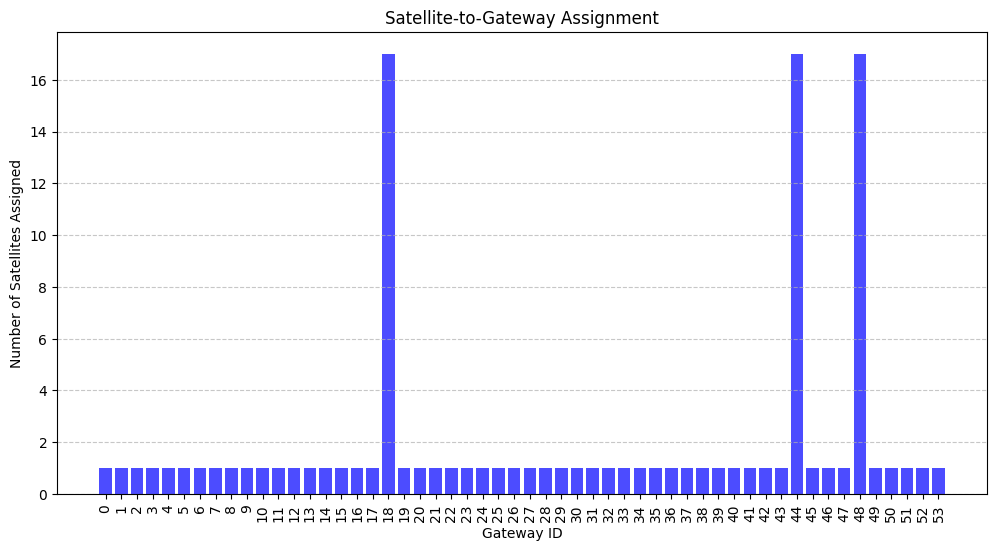


Sample Predictions:
Satellite 950 → Final Gateway: 49, Actual: 20
Satellite 1064 → Final Gateway: 0, Actual: 34
Satellite 1245 → Final Gateway: 3, Actual: 5
Satellite 1246 → Final Gateway: 1, Actual: 30
Satellite 1564 → Final Gateway: 52, Actual: 42
Satellite 1267 → Final Gateway: 5, Actual: 7
Satellite 927 → Final Gateway: 44, Actual: 52
Satellite 1335 → Final Gateway: 7, Actual: 41
Satellite 1223 → Final Gateway: 2, Actual: 31
Satellite 1087 → Final Gateway: 4, Actual: 53


In [7]:
import torch
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta
from torch_geometric.data import Data

# Load trained models
gnn_model = GNNModel(input_dim=57, hidden_dim=128, output_dim=54)  # FIXED INPUT DIMENSION
gnn_model.load_state_dict(torch.load('gnn_model.pth'))
gnn_model.eval()

nn_model = tf.keras.models.load_model('gateway_model.h5')
scaler = joblib.load('scaler.save')

# Set folder paths
FOLDER_POSITION = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\pos"
FOLDER_OPTIMAL = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position"

# Generate testing timestamps
def generate_test_time_files(start_time_str, num_files=5):
    """Generate file paths for test timestamps (after training)."""
    start_time = datetime.strptime(start_time_str, '%H_%M_%S') + timedelta(seconds=200)
    current_time = start_time
    time_files = []

    for _ in range(num_files):
        time_str = current_time.strftime('%H_%M_%S')
        file_name = f"optimal_file_data_{time_str}.csv"
        time_files.append(os.path.join(FOLDER_OPTIMAL, file_name))
        current_time += timedelta(seconds=20)

    return time_files

test_files = generate_test_time_files("16_00_00", num_files=5)

### Load Test Satellite Data
def load_test_satellites(file_path):
    """Loads unique satellites for a test timestamp."""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return []

    df = pd.read_csv(file_path)
    df = df[(df['Latitude'] >= LAT_MIN) & (df['Latitude'] <= LAT_MAX) & 
            (df['Longitude'] >= LON_MIN) & (df['Longitude'] <= LON_MAX)]
    df = df.drop_duplicates(subset=['feed_sat'])

    satellites = [{'id': int(row['feed_sat']), 
                   'position': {'Latitude': row['Latitude'], 'Longitude': row['Longitude'], 'Altitude': row['Altitude']},
                   'actual_gateway': int(row['gw'])} for _, row in df.iterrows()]
    
    return satellites

### Predict Initial Gateways (NN Model)
def predict_gateways_for_satellites(satellites):
    """Predicts top-3 gateways using NN model."""
    if not satellites:
        return []

    positions = np.array([[sat['position']['Latitude'], sat['position']['Longitude'], sat['position']['Altitude']] for sat in satellites])
    positions_scaled = scaler.transform(positions)
    predictions = nn_model.predict(positions_scaled)
    top_3_gateways = np.argsort(predictions, axis=1)[:, -3:]

    for i, sat in enumerate(satellites):
        sat['predicted_gateways'] = top_3_gateways[i].tolist()

    return satellites

### Construct Graph for Testing
def construct_graph(satellites, edges):
    num_gateways = 54  # Total number of possible gateways
    node_features = []

    for sat in satellites:
        lat, lon, alt = sat['position']['Latitude'], sat['position']['Longitude'], sat['position']['Altitude']
        predicted_gateways = sat.get('predicted_gateways', [])

        # Ensure exactly 3 predicted gateways (pad if needed)
        while len(predicted_gateways) < 3:
            predicted_gateways.append(0)  # Use 0 as a placeholder

        # One-hot encode the top-3 predicted gateways
        one_hot_gateways = np.zeros(num_gateways)
        for gw in predicted_gateways:
            if 0 <= gw < num_gateways:  # Ensure within range
                one_hot_gateways[gw] = 1  

        # **Ensure 57 features total**
        feature_vector = [lat, lon, alt] + one_hot_gateways.tolist()
        assert len(feature_vector) == 57, f"Feature vector length mismatch: {len(feature_vector)}"

        node_features.append(feature_vector)

    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=node_features, edge_index=edge_index)

### Run the Trained GNN on Test Data
def test_gnn_model(satellites):
    """Tests the trained GNN model on unseen data."""
    edges = find_nearest_neighbors(satellites, k=4)
    graph_data = construct_graph(satellites, edges)

    with torch.no_grad():
        refined_gateways = gnn_model(graph_data).argmax(dim=1).tolist()

    for i, sat in enumerate(satellites):
        sat['gnn_predicted_gateway'] = refined_gateways[i]

    return satellites

### Balance Gateway Assignments
def balance_gateways(satellites, num_gateways=54):
    """Ensures all gateways have at least one satellite assigned."""
    assignment_counts = np.zeros(num_gateways, dtype=int)
    satellite_assignments = {}

    # Initial assignment from GNN predictions
    for i, sat in enumerate(satellites):
        assigned_gateway = sat.get('gnn_predicted_gateway', np.random.randint(0, num_gateways))
        satellite_assignments[i] = assigned_gateway
        assignment_counts[assigned_gateway] += 1

    # Identify unassigned gateways
    unassigned_gateways = [gw for gw in range(num_gateways) if assignment_counts[gw] == 0]

    # Redistribute satellites from overloaded gateways
    for missing_gateway in unassigned_gateways:
        max_gateway = np.argmax(assignment_counts)
        for sat_id, assigned_gateway in satellite_assignments.items():
            if assigned_gateway == max_gateway:
                satellite_assignments[sat_id] = missing_gateway
                assignment_counts[max_gateway] -= 1
                assignment_counts[missing_gateway] += 1
                break

    # Assign `final_gateway` to all satellites
    for i, sat in enumerate(satellites):
        sat['final_gateway'] = satellite_assignments.get(i, -1)  # Assign -1 if something fails

    return satellites

### **Bar Chart - Gateway Assignments**
def plot_gateway_distribution(satellites):
    """Creates a bar chart showing satellite count per gateway."""
    gateway_counts = Counter(sat['final_gateway'] for sat in satellites)

    plt.figure(figsize=(12, 6))
    plt.bar(gateway_counts.keys(), gateway_counts.values(), color='blue', alpha=0.7)
    plt.xticks(range(54), rotation=90)
    plt.xlabel("Gateway ID")
    plt.ylabel("Number of Satellites Assigned")
    plt.title("Satellite-to-Gateway Assignment")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display gateways without satellites
    unassigned_gateways = [gw for gw in range(54) if gw not in gateway_counts]
    print("\nGateways without satellites:", unassigned_gateways)

    plt.show()

### **Process Testing Data**
def process_test_data(file_path):
    """Processes a test file, applies the GNN model, and evaluates performance."""
    satellites = load_test_satellites(file_path)
    if not satellites:
        return

    print(f"\nProcessing test file: {file_path}")
    satellites = predict_gateways_for_satellites(satellites)
    satellites = test_gnn_model(satellites)
    satellites = balance_gateways(satellites)

    # **Plot Bar Chart**
    plot_gateway_distribution(satellites)

    # Print Sample Predictions
    print("\nSample Predictions:")
    for sat in satellites[:10]:  # Print only the first 10 satellites
        print(f"Satellite {sat['id']} → Final Gateway: {sat['final_gateway']}, Actual: {sat['actual_gateway']}")

### **Run Testing for All Test Files**
for file_path in test_files:
    process_test_data(file_path)


In [8]:
import pandas as pd
import os

def generate_gateway_summary(satellites, file_path, output_folder="results"):
    """Generates a table summarizing satellite gateway assignments and saves it in the 'results' folder."""

    # Extract timestamp from the filename (assuming format: optimal_file_data_HH_MM_SS.csv)
    file_name = os.path.basename(file_path)
    timestamp = file_name.replace("optimal_file_data_", "").replace(".csv", "")

    # Ensure the results folder exists
    os.makedirs(output_folder, exist_ok=True)  # Creates "results" folder if it doesn't exist

    # Define full output file path
    output_file = os.path.join(output_folder, f"gateway_summary_{timestamp}.csv")

    # Prepare data
    gateway_summary = []

    for sat in satellites:
        gateway_summary.append({
            "Satellite": sat['id'],
            "Final Gateway Assigned": sat['final_gateway'],
            "Predicted 3 Gateways": sat['predicted_gateways'],
            "Actual Gateway": sat['actual_gateway']
        })

    # Convert to DataFrame
    df_summary = pd.DataFrame(gateway_summary)

    # Save to CSV
    df_summary.to_csv(output_file, index=False)

    print(f"✅ Gateway summary saved in '{output_file}'")
    return df_summary



In [9]:
for file_path in test_files:
    satellites = load_test_satellites(file_path)
    if not satellites:
        continue

    satellites = predict_gateways_for_satellites(satellites)
    satellites = test_gnn_model(satellites)
    satellites = balance_gateways(satellites)

    # Generate and save the gateway summary in the 'results' folder
    print(f"\nGateway Assignment Summary for {file_path}:")
    gateway_summary_df = generate_gateway_summary(satellites, file_path)

    # Display the table
    print(gateway_summary_df.head())  # Print first few rows

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Gateway Assignment Summary for C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_03_20.csv:
✅ Gateway summary saved in 'results\gateway_summary_16_03_20.csv'
   Satellite  Final Gateway Assigned Predicted 3 Gateways  Actual Gateway
0        950                      45          [25, 4, 47]              20
1       1064                       8          [35, 34, 4]              34
2       1040                       0          [39, 43, 5]               5
3       1269                      10         [19, 31, 30]              30
4       1518                      49         [32, 36, 17]              36
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Gateway Assignment Summary for C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position\optimal_file_data_16_03_40.csv:
✅ Gateway summary saved in 'results\gateway_summary_16_03_40.csv'
   Satellite  Final Gateway Assigned Predicted 3 Gateways  Actual Gateway
0        904        